<small>This Example is from the textbook 
<b>Supply Chain Management: Strategy, Planning, and Operation, (Chopra and Meindl)</b>
</small>

# Estimation of Safety inventory

Safety inventory can help a supply chain improve product availability in the presence of supply and demand variability.

![image.png](../../docs/img/safety_inv_est_files/safety_inv_est_profile.png)

__Example:__ Bloomingdale sells Gucci purses. Demand is 100 per week. Gucci takes 3 weeks to deliver purses to Bloomingdale in response to an order. Therfore Bloomingdale can place an order when exactly 300 purses are remaining in the inventory.

Given deand fluctuations, demand over three weeks may be higher or lower than that of 300. If it is higher, Bloomingdale will lose sales. The store manager decides to put an order of 400 purses (therfore, safety level is 100).

__Goal:__ To determine the appropriate level of safety inventory.

__Replinishment policies:__
  1. __Continuous review:__ Inventory is continuously tracked, and an order for a lot size Q is placed when the inventory declines to the reorder point (ROP). As an example, consider the store manager at B&M who continuously tracks the inventory of phones. She orders 600 phones when the inventory drops below ROP 400. In this case, the size of the order does not change from one order to the next. The time between orders may fluctuate given variable demand.
  2. __Periodic review:__ Inventory status is checked at regular periodic intervals, and an order is placed to raise the inventory level to a specified threshold. As an example, consider the purchase of film at B&M. The store manager does not track film inventory continuously. Every Thursday, employees check film inventory, and the manager orders enough so that the total of the available inventory and the size of the order equals 1,000 films. In this case, the time between orders is fixed. The size of each order, however, can fluctuate given variable demand.

## Numerical Example

__Evaluating Safety Inventory Given an Inventory Policy__

Assume that weekly demand for phones at B&M Office Supplies is normally distributed, with a mean of 2,500 and a standard deviation of 500. The manufacturer takes two weeks to fill an order placed by the B&M manager. The store manager currently orders 10,000 phones when the inventory on hand drops to 6,000. Evaluate the safety inventory and the average inventory carried by B&M. Also evaluate the average time a phone spends at B&M.

__Analytical Solution:__<br>
Under this replenishment policy, we have <br>
Average demand per week, $D = 2500$ <br>
Standard deviation of weekly demand, $\sigma_D = 500$ <br>
Average lead tme for replenishment, $L = 2$ Weeks <br>
Reorder point $ROP = 6000$ <br>
Average lot size $Q = 10000$ <br>

using eq 12.3 in the textbook,

safety inv, $ss = ROP - D^*L = 6000-5000 = 1000$ <br>
B&M thus carries a safety inventory of 1,000 phones.<br>

Cycle inventory = $\frac{Q}{3} = \frac{10000}{2} = 5000$

Average inventory = cycle inventory + safety inventory $= 5000 + 1000 = 6000$

Average flow time = average inventory/throughput $= \frac{6000}{2500} = 2.4$ weeks

__System:__

![image.png](../../docs/img/safety_inv_est_files/safety_inv_est_sc.png)

Cost per unit, transportation cost is not given. So we can assume anything. We want to find<br> 
- Safety inventory level (the average number of phones on hand when a replenishment order arrives).
- Cycle inventory (average inventory levels) 
- Average flowtime (average time spent by a product in the inventory)





	***
Safety Stock Level:  1315.2294619614904
Average Inventory Level: 6207.3688497299245
Average Flow Time:  13.57089552238806 days 



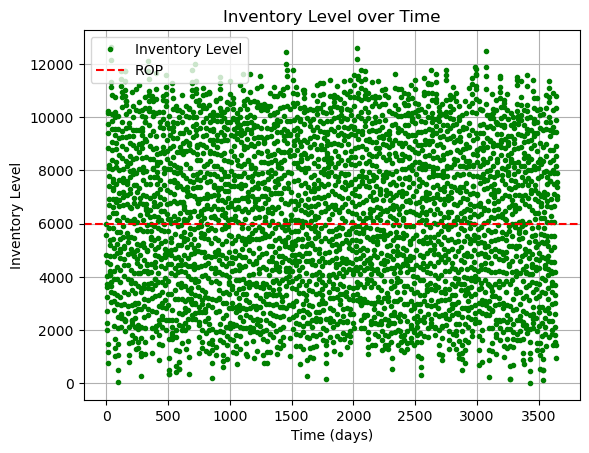

In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import SupplyNetPy.Components as scm

daily_demand_mean = 2500/7
daily_demand_std = 500/(7**0.5)
simlen = 3650 # simulation length in days

def normal_quantity():
    global daily_demand_mean, daily_demand_std
    sample = -1
    while sample < 0:
        sample = np.random.normal(daily_demand_mean, daily_demand_std, 1)[0]
    return sample

env = simpy.Environment()
# create an infinite supplier
supplier1 = scm.Supplier(env=env, ID="S1", name="Supplier1", node_type="infinite_supplier")
#create the distributor
distributor1 = scm.InventoryNode(env=env, ID="D1", name="Distributor1", node_type="distributor", capacity=float('inf'), initial_level=6000, inventory_holding_cost=0.1,
                                product_buy_price=0, replenishment_policy=scm.RQReplenishment, policy_param={'R':6000,'Q':10000}, product_sell_price=399)
link1 = scm.Link(env=env,ID="l1", source=supplier1, sink=distributor1, cost=100, lead_time=lambda: 14)
demand1 = scm.Demand(env=env,ID="d1", name="demand_d1", order_arrival_model=lambda: 1, order_quantity_model=normal_quantity, demand_node=distributor1)
scm.global_logger.disable_logging() # disable logging
env.run(until=simlen)

# calculate performance metrics
safety_stock = []
replenish_cycles = [0]

inv_levels = np.array(distributor1.inventory.instantaneous_levels) # instantaneous inventory levels
# lets calculate safety stock level
for i in range(len(inv_levels)-1):
    if(inv_levels[i,1]<inv_levels[i+1,1]): # inventory level is increasing that means a replenishment order is received
        safety_stock.append(inv_levels[i,1])
        replenish_cycles.append(inv_levels[i,0]) # time of replenishment order

# calculate average flow time (amount of time an item is stored in inventory)
flow_time = []
for i in range(len(replenish_cycles)-1):
    flow_time.append(replenish_cycles[i+1]-replenish_cycles[i])

print("\n\t***\nSafety Stock Level: ", np.mean(safety_stock))
print("Average Inventory Level:", np.mean(inv_levels[:,1]))
print("Average Flow Time: ", np.mean(flow_time)/2, "days","\n")

# plot the inventory level over time
plt.plot(inv_levels[:,0], inv_levels[:,1], marker='.', label="Inventory Level", color='green', linestyle='')
plt.axhline(y=6000, color='r', linestyle='--', label="ROP")
plt.xlabel("Time (days)")
plt.ylabel("Inventory Level")
plt.title("Inventory Level over Time")
plt.legend()
plt.grid()
plt.show()

Since the demand at the B&M office is unpredictable, we will estimate the safety inventory by conducting multiple simulations. First, we will define a function to simulate the B&M office sales. We will then use this function to run several simulations.

In [2]:
def bnmoffice():
    env = simpy.Environment()

    # create an infinite supplier
    supplier1 = scm.Supplier(env=env, ID="S1", name="Supplier1", node_type="infinite_supplier")

    #create the distributor
    distributor1 = scm.InventoryNode(env=env, ID="D1", name="Distributor1", node_type="distributor", capacity=16000, initial_level=6000, inventory_holding_cost=0.1,
                                    product_buy_price=0, replenishment_policy=scm.SSReplenishment, policy_param={'s':6000,'S':16000}, product_sell_price=399)

    link1 = scm.Link(env=env,ID="l1", source=supplier1, sink=distributor1, cost=100, lead_time=lambda: 14)

    demand1 = scm.Demand(env=env,ID="d1", name="demand_d1", order_arrival_model=lambda: 1, order_quantity_model=normal_quantity, demand_node=distributor1)

    scm.global_logger.disable_logging() # disable logging
    env.run(until=simlen)

    # calculate performance metrics
    safety_stock = []
    replenish_cycles = [0]

    inv_levels = np.array(distributor1.inventory.instantaneous_levels) # instantaneous inventory levels
    # lets calculate safety stock level
    for i in range(len(inv_levels)-1):
        if(inv_levels[i,1]<inv_levels[i+1,1]): # inventory level is increasing that means a replenishment order is received
            safety_stock.append(inv_levels[i,1])
            replenish_cycles.append(inv_levels[i,0]) # time of replenishment order

    # calculate average flow time (amount of time an item is stored in inventory)
    flow_time = []
    for i in range(len(replenish_cycles)-1):
        flow_time.append(replenish_cycles[i+1]-replenish_cycles[i])

    return np.mean(safety_stock), np.mean(inv_levels[:,1]), np.mean(flow_time)/2

num_simulations = 100
ana_arr = [] # let us gather all stats in this variable
for i in range(0,num_simulations):
    ana_arr.append([])
    safety_stock, avg_inv, flow_t = bnmoffice()
    ana_arr[-1].extend([safety_stock, avg_inv, flow_t])

ana_arr = np.array(ana_arr) # convert to array for convenience
#Final Stats
print("\n\t***\nSafety Stock Level: Mean: ", np.mean(ana_arr[:,0]), " Std:", np.std(ana_arr[:,0]))
print("Average Inventory Level:", np.mean(ana_arr[:,1]), " Std:",  np.std(ana_arr[:,1]))
print("Average Flow Time: ", np.mean(ana_arr[:,2]), "days","\n", " Std:",  np.std(ana_arr[:,2]))


	***
Safety Stock Level: Mean:  1347.9523813366336  Std: 54.85624022638165
Average Inventory Level: 6315.472134834441  Std: 42.11831759963809
Average Flow Time:  13.820451583252883 days 
  Std: 0.1074252955034431


We obtain a slightly higher safety level, and average inventory levels from the simulation because sampling from a normal distribution can yield a few values less than zero. In our method, `normal_quantity()`, we resample in such cases to ensure that we only get numbers that are greater than or equal to zero, as negative demand is not possible. This resampling increases the probability of obtaining positive values. We will demonstrate this further below.

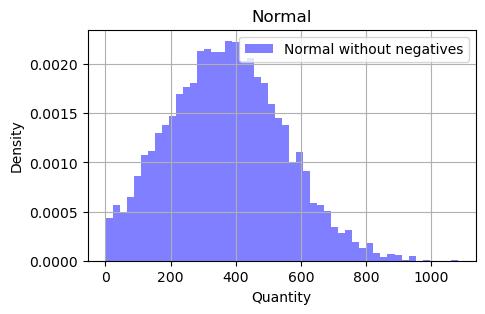

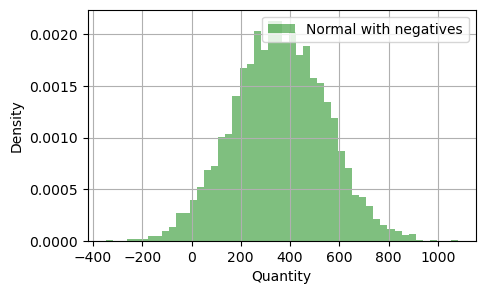

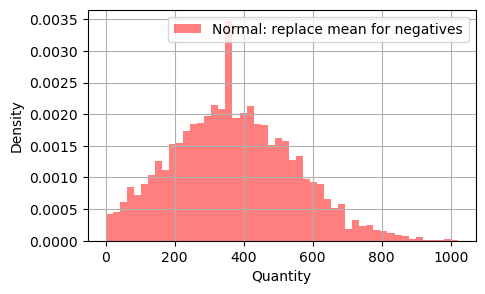

In [3]:
def normal_quantity():
    """
    Normal Distribution with given mean, and std
    A new sample is generated for every negative sample
    """
    global daily_demand_mean, daily_demand_std
    sample = -1
    while sample < 0:
        sample = np.random.normal(daily_demand_mean, daily_demand_std, 1)[0]
    return sample

def normal_quantity_mean():
    """
    Normal Distribution with given mean, and std
    The mean value replaces a negative sample
    """
    global daily_demand_mean, daily_demand_std
    sample = np.random.normal(daily_demand_mean, daily_demand_std, 1)[0]
    if sample < 0:
        sample = daily_demand_mean
    return sample

def normal_quantity_wn():
    """
    Normal Distribution with given mean, and std including negatives
    """
    global daily_demand_mean, daily_demand_std
    sample = np.random.normal(daily_demand_mean, daily_demand_std, 1)[0]
    return sample

samples = []
samples_wn = []
samples_mean = []
for r in range(5000):
    samples.append(normal_quantity())
    samples_wn.append(normal_quantity_wn())
    samples_mean.append(normal_quantity_mean())

plt.figure(figsize=(5, 3))
plt.hist(samples, bins=50, density=True, alpha=0.5, color='blue', label='Normal without negatives')
plt.title('Normal')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.grid()
plt.legend()

plt.figure(figsize=(5, 3))
plt.hist(samples_wn, bins=50, density=True, alpha=0.5, color='green', label='Normal with negatives')
#plt.title('Normal without negative quantities')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.grid()
plt.legend()

plt.figure(figsize=(5, 3))
plt.hist(samples_mean, bins=50, density=True, alpha=0.5, color='red', label='Normal: replace mean for negatives')
#plt.title('Normal with mean for negative quantities')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.grid()
plt.legend()